# Creating Seasonal Forecasting Dashboards in Python

Welcome to the technical training on data integration in seasonal forecasting, made by HKV. 

1. [Section 1: TAHMO data](#section-1)
2. [Section 2: Introduction to web apps in Solara](#section-2)
3. [Section 3: Building a seasonal forecast dashboard](#section-3)


### Section 1: TAHMO data


In [1]:
import TAHMO

# The demo credentials listed below give you access to three pre-defined stations. 
# Please use the API credentials provided to you to get access to all stations configured for you specifically.
api = TAHMO.apiWrapper()
api.setCredentials('demo', 'DemoPassword1!')

station = 'TA00016'
station_data = api.getStations()[station]

print()
print( f"Station name =  {station_data['location']['name']}")
print( f"Longitude =  {station_data['location']['longitude']:.02f}")
print( f"Latitude =  {station_data['location']['latitude']:.02f}")

API request: services/assets/v2/stations

Station name =  Accra Academy School, Accra
Longitude =  -0.24
Latitude =  5.57


In [2]:
# Example 1: Get metadata from all stations that your account has access to.

# stations = api.getStations()
# print('Account has access to stations: %s' % ', '.join(list(stations)))

In [3]:
# Example 2: Get all variables and units from the TAHMO API.

# variables = api.getVariables()
# print('Available variables in TAHMO API:')
# for variable in variables:
#     print('%s [%s] with shortcode "%s"' %
#           (variables[variable]['description'], variables[variable]['units'], variables[variable]['shortcode']))

API request: services/measurements/v2/stations/TA00016/measurements/controlled
Timeseries saved to file "timeseries.csv"


<Axes: xlabel='Timestamp'>

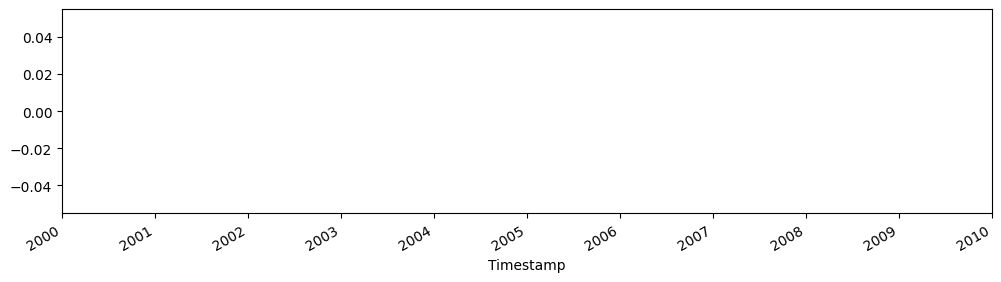

In [4]:
# Example 3: Retrieve a pandas dataframe containing the time serie of surface air observations and save to CSV file.


startDate = '08/08/2023'
endDate = '01/11/2023'
variables = ['pr']

df = api.getMeasurements(station, startDate=startDate, endDate=endDate, variables=variables)
df.index.name = 'Timestamp'
df.to_csv('timeseries.csv', na_rep='', date_format='%Y-%m-%d %H:%M')
print('Timeseries saved to file "timeseries.csv"')

import pandas as pd
df = pd.read_csv('timeseries.csv', index_col='Timestamp', parse_dates=True)
df['pr'].plot(figsize=(12,3))

### Section 2: Open-meteo data

In [16]:
import requests


def get_ecmwf_precipitation(api_key, lon, lat):
    base_url = "https://api.open-meteo.com/v1/forecast"
    
    # Specify the parameters for the ECMWF precipitation forecast
    params = {
        "longitude" : lon,
        "latitude" : lat,
        "daily" : "precipitation_sum",
        # "start_date" : startDate,
        # "end_date" : endDate,
        "past_days" : 90,
        "timezone" : "auto",
        "hourly" : "precipitation",
        "start" : "current",
        "forecast_days" : 10,
        "models" : "ecmwf_ifs04", 
        "apikey" : api_key,
    }

    try:
        # Make a request to the Open-Meteo API
        response = requests.get(base_url, params=params)
        data = response.json()
        return data
    except requests.RequestException as e:
        print(f"Error: {e}")

data = get_ecmwf_precipitation('', lon=station_data['location']['longitude'], lat=station_data['location']['latitude'])

In [17]:
data

{'latitude': 5.5999985,
 'longitude': -0.3999939,
 'generationtime_ms': 25.744080543518066,
 'utc_offset_seconds': 0,
 'timezone': 'Africa/Accra',
 'timezone_abbreviation': 'GMT',
 'elevation': 24.0,
 'hourly_units': {'time': 'iso8601', 'precipitation': 'mm'},
 'hourly': {'time': ['2023-08-24T00:00',
   '2023-08-24T01:00',
   '2023-08-24T02:00',
   '2023-08-24T03:00',
   '2023-08-24T04:00',
   '2023-08-24T05:00',
   '2023-08-24T06:00',
   '2023-08-24T07:00',
   '2023-08-24T08:00',
   '2023-08-24T09:00',
   '2023-08-24T10:00',
   '2023-08-24T11:00',
   '2023-08-24T12:00',
   '2023-08-24T13:00',
   '2023-08-24T14:00',
   '2023-08-24T15:00',
   '2023-08-24T16:00',
   '2023-08-24T17:00',
   '2023-08-24T18:00',
   '2023-08-24T19:00',
   '2023-08-24T20:00',
   '2023-08-24T21:00',
   '2023-08-24T22:00',
   '2023-08-24T23:00',
   '2023-08-25T00:00',
   '2023-08-25T01:00',
   '2023-08-25T02:00',
   '2023-08-25T03:00',
   '2023-08-25T04:00',
   '2023-08-25T05:00',
   '2023-08-25T06:00',
   '2023

<Axes: xlabel='time'>

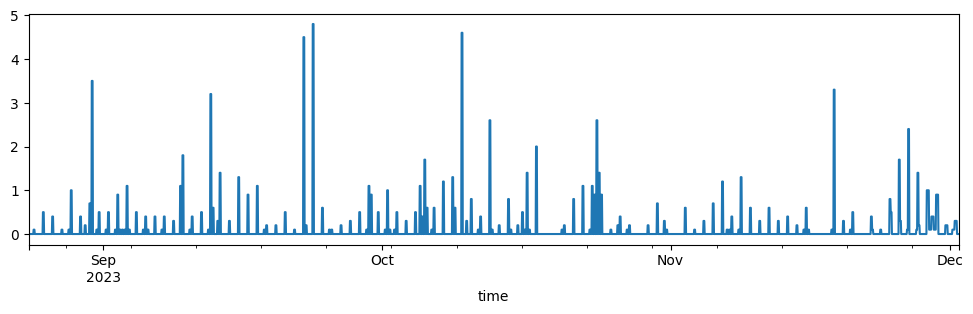

In [18]:
df = pd.DataFrame.from_dict(data['hourly'])

df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df['precipitation'].plot(figsize=(12,3))

In [28]:
df.iloc[:100*24]

,precipitation
time,
2023-08-24 00:00:00,0.0
2023-08-24 01:00:00,0.0
2023-08-24 02:00:00,0.0
2023-08-24 03:00:00,0.0
2023-08-24 04:00:00,0.0
...,...
2023-12-01 19:00:00,0.0
2023-12-01 20:00:00,0.0
2023-12-01 21:00:00,0.0


In [1]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/ecmwf"
params = {
	"latitude": station_data['location']['latitude'],
	"longitude": station_data['location']['longitude']
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

NameError: name 'station_data' is not defined